
# Generative Adversarial Networks

`Generative Adversarial Networks` consist od 2 neural networks. `Generator` creates images from noise and gets feedback from `Discriminator` which aim is to determine whether given picture is generated or real. Then the feeback goes to the Generator and it gets retrained in a loop so that both Generator and Discriminator get better and better. 

When updating the Generator, the `Discriminator weights are frozen` as while updating we `label all imagages as real`. In this way those classified by discriminator as false will have impact on generator while retraining it. We will update weights of generator in a way that its output fits the discriminator in such way that it classifies it as real and then we get min loss in the end (all images labeled as real in this step)
![alt text](GAN.png "Title")

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

#### Data

In [4]:
(X_train, _), _ = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32) / 255

In [5]:
BATCH_SIZE = 128
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

#### Model

In [6]:
random_normal_dimensions=32

`generator`

In [7]:
generator=tf.keras.models.Sequential([
    tf.keras.layers.Dense(64,activation='selu',input_shape=[random_normal_dimensions]),
    tf.keras.layers.Dense(128,activation='selu'),
    tf.keras.layers.Dense(28*28,activation='sigmoid'),
    tf.keras.layers.Reshape([28,28])
])

In [8]:
test_noise = tf.random.normal([16, random_normal_dimensions])
test_image = generator(test_noise)

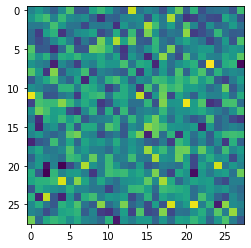

In [9]:
plt.imshow(test_image[0])

`discriminator`

In [10]:
discriminator=tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[28,28]),
    tf.keras.layers.Dense(128,activation='selu'),
    tf.keras.layers.Dense(64,activation='selu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

`GAN`

In [11]:
discriminator.compile(optimizer=tf.keras.optimizers.RMSprop(),loss=tf.keras.losses.binary_crossentropy)
discriminator.trainable=False
gan=tf.keras.models.Sequential([generator,discriminator])
gan.compile(optimizer=tf.keras.optimizers.RMSprop(),loss=tf.keras.losses.binary_crossentropy)

#### Training

Standard Neural Networks with GAN's have the tendency to skew to the more `simple digits` to trick the discriminator. After more trining epochs generator focuses on producing 1's and 7's more simple digits.

In [ ]:
def train_gan(gan, dataset, random_normal_dimensions, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))       
        for real_images in dataset:
            batch_size = real_images.shape[0]
            
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])
            fake_images = generator(noise)
            mixed_images = tf.concat([fake_images, real_images], axis=0)
            discriminator_labels = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(mixed_images, discriminator_labels)
            
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])
            generator_labels = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, generator_labels)

In [ ]:
train_gan(gan, dataset, random_normal_dimensions, n_epochs=20)

---

## DCGAN

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

C:\Users\pk764\miniconda3\envs\data\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Data

In [3]:
(X_train, _), _ = tf.keras.datasets.fashion_mnist.load_data()
X_train = X_train.astype(np.float32) / 255
X_train = X_train.reshape(-1, 28, 28, 1) * 2. - 1.

BATCH_SIZE = 128
dataset = tf.data.Dataset.from_tensor_slices(X_train)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

#### Model

In [4]:
random_normal_dimensions=32

`generator`

In [10]:
generator=tf.keras.models.Sequential([
    tf.keras.layers.Dense(7*7*128,input_shape=[random_normal_dimensions]),
    tf.keras.layers.Reshape([7,7,128]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(64,(5,5),strides=2,padding='same',activation='selu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(1,(5,5),strides=2,padding='same',activation='tanh'),
])
generator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 6272)              206976    
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 batch_normalization_2 (Batc  (None, 7, 7, 128)        512       
 hNormalization)                                                 
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 14, 14, 64)       204864    
 ranspose)                                                       
                                                                 
 batch_normalization_3 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                      

In [6]:
test_noise = tf.random.normal([16, random_normal_dimensions])
test_image = generator(test_noise)

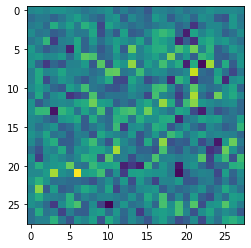

In [7]:
plt.imshow(test_image[0])

`discriminator`

In [9]:
discriminator=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64,(5,5),strides=2,activation=tf.keras.layers.LeakyReLU(0.2),padding='same',input_shape=[28, 28, 1]),
    tf.keras.layers.Dropout(0,4),
    tf.keras.layers.Conv2D(128,(5,5),strides=2,activation=tf.keras.layers.LeakyReLU(0.2),padding='same'),
    tf.keras.layers.Dropout(0,4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 6273      
                                                                 
Total params: 212,865
Trainable params: 212,865
Non-tr

`CNN GAN`

In [11]:
discriminator.compile(optimizer=tf.keras.optimizers.RMSprop(),loss=tf.keras.losses.binary_crossentropy)
discriminator.trainable=False

gan=tf.keras.models.Sequential([generator,discriminator])
gan.compile(optimizer=tf.keras.optimizers.RMSprop(),loss=tf.keras.losses.binary_crossentropy)

#### Training

In [12]:
def train_gan(gan, dataset, random_normal_dimensions, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))       
        for real_images in dataset:
            batch_size = real_images.shape[0]
            
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])
            fake_images = generator(noise)
            mixed_images = tf.concat([fake_images, real_images], axis=0)
            discriminator_labels = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(mixed_images, discriminator_labels)
            
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])
            generator_labels = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, generator_labels)

In [ ]:
train_gan(gan, dataset, random_normal_dimensions, n_epochs=20)

---

## Face GAN

#### Model

`generator`

In [21]:
input_shape=(1,1,128)

In [19]:
inputs=x=tf.keras.layers.Input(shape=input_shape)
x=tf.keras.layers.Conv2DTranspose(512,(4,4),strides=1,padding='valid',use_bias=False)(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.ReLU()(x)

x=tf.keras.layers.Conv2DTranspose(256,(4,4),strides=1,padding='same',use_bias=False)(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.ReLU()(x)

x=tf.keras.layers.Conv2DTranspose(128,(4,4),strides=1,padding='same',use_bias=False)(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.ReLU()(x)

x=tf.keras.layers.Conv2DTranspose(64,(4,4),strides=1,padding='same',use_bias=False)(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.ReLU()(x)

x=tf.keras.layers.Conv2DTranspose(3,(4,4),strides=1,padding='same')(x)
outputs=tf.keras.layers.Activation('tanh')(x)

`discriminator`

In [20]:
inputs=x=tf.keras.layers.Input(shape=input_shape)
x=tf.keras.layers.Conv2D(64,(4,4),strides=2,padding='same')(x)
x=tf.keras.layers.LeakyReLU(0.2)(x)

x=tf.keras.layers.Conv2D(128,(4,4),strides=2,padding='same',use_bias=False)(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.LeakyReLU(0.2)(x)

x=tf.keras.layers.Conv2D(256,(4,4),strides=2,padding='same',use_bias=False)(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.LeakyReLU(0.2)(x)

x=tf.keras.layers.Conv2D(512,(4,4),strides=2,padding='same',use_bias=False)(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.LeakyReLU(0.2)(x)

outputs=tf.keras.layers.Conv2D(1,(4,4),padding='valid')(x)